In [1]:
import pandas as pd
import numpy as np
import re
import datetime as dt
from datetime import timedelta, datetime, time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from scipy.stats import entropy
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score



In [2]:
path = '/content/drive/MyDrive/Aviator/Data1/bd_pseudo_1.csv'
data = pd.read_csv(path)
print(data)
t = 0
print(len(data))
t0 = int(input("Maximo: "))
tamanho_data = len(data)

odd = []
horario = []
odd_ajustada = []

while t <= t0:
    if t < tamanho_data:
        value = data['odd'][t]
        if isinstance(value, float):
            odd.append(np.nan)  # or any other value to represent missing data
        else:
            aux = value.split('\n\n')
            a1 = aux[0].replace(')I', '')
            a2 = a1.replace(')', '')
            a3 = a2.replace('|', '1')
            a4 = a3.replace('?', '7')
            a5 = re.sub('[^0-9.]', '', a4)
            odd.append(float(a5))
        horario.append(data['hora_criacao'][t])

    t += 1

for name in odd:
    ajuste = float(name - 1.25)
    odd_ajustada.append(ajuste)

horas = []
minutos = []
segundos = []
for item in horario:
    dt = datetime.strptime(item, "%a %b %d %H:%M:%S %Y")
    horas.append(dt.hour)
    minutos.append(dt.minute)
    segundos.append(dt.second)

data1 = pd.DataFrame({'Odd_ajustada': odd, 'hora': horas, 'minutos': minutos, 'segundos': segundos, 'horario': horario})

###Data final
#data = dados_filtrados
data = data1

# Verificar se existem valores NaN na coluna "Odd_ajustada"
has_nan = data['Odd_ajustada'].isna().any()
if has_nan:
    print("Existem valores NaN na coluna 'Odd_ajustada'.")
else:
    print("Não existem valores NaN na coluna 'Odd_ajustada'.")


          id    odd              hora_criacao apostadores
0          0  13.89  Sat May 27 00:28:06 2023        1650
1          1   1.44  Sat May 27 00:28:18 2023       22211
2          2   3.39  Sat May 27 00:28:42 2023        1751
3          3   1.27  Sat May 27 00:28:56 2023        1950
4          4   5.16  Sat May 27 00:29:26 2023        2086
...      ...    ...                       ...         ...
37852  37855   1.53  Fri Oct 20 23:00:27 2023           
37853  37856   1.36  Fri Oct 20 23:00:45 2023        181
37854  37857   1.00  Fri Oct 20 23:00:59 2023       1882
37855  37858   2.17  Fri Oct 20 23:01:20 2023          1
37856  37859   2.12  Fri Oct 20 23:01:46 2023           

[37857 rows x 4 columns]
37857
Maximo: 37857
Não existem valores NaN na coluna 'Odd_ajustada'.


In [3]:
data1 = data

In [4]:
geral_cat = []
for name in data['Odd_ajustada']:
  #print(name)
  if name < 1.05:
    geral_cat.append(1)
  elif name >= 1.05 and name < 1.15:
    geral_cat.append(2)
  elif name >= 1.15 and name < 1.3:
    geral_cat.append(3)
  elif name >= 1.3 and name < 1.45:
    geral_cat.append(4)
  elif name >= 1.45 and name < 1.7:
    geral_cat.append(5)
  elif name >= 1.7 and name < 2.1:
    geral_cat.append(6)
  elif name >= 2.1 and name < 2.6:
    geral_cat.append(7)
  elif name >= 2.6 and name < 3.5:
    geral_cat.append(8)
  elif name >= 3.5 and name < 5:
    geral_cat.append(9)
  elif name >= 5 and name < 10:
    geral_cat.append(10)
  elif name >= 10:
    geral_cat.append(11)
print(len(geral_cat))
geral_cat1 = pd.DataFrame([geral_cat]).T
geral_cat1.columns = ['Odd_Categoria']
data = pd.concat([data, geral_cat1], axis = 1)

data['Odd_Categoria'].describe()

37857


count    37857.000000
mean         6.114536
std          3.090147
min          1.000000
25%          3.000000
50%          6.000000
75%          9.000000
max         11.000000
Name: Odd_Categoria, dtype: float64

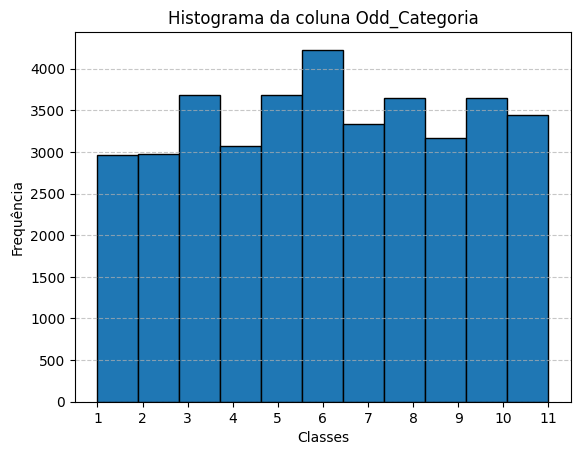

In [5]:
# Configurar o histograma
plt.hist(data['Odd_Categoria'], bins=11, edgecolor='k')  # O número de bins deve corresponder ao número de classes (12 no seu caso)
plt.title('Histograma da coluna Odd_Categoria')
plt.xlabel('Classes')
plt.ylabel('Frequência')
plt.xticks(range(1, 12))  # Rótulos do eixo x de 1 a 12
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar o histograma
plt.show()


In [6]:
# Crie as colunas "entrada" e "saida" deslocando a coluna "horario" para cima
new_data = pd.DataFrame()
new_data['odd_saida'] = data['Odd_Categoria']
new_data['odd_eentrada'] = data['Odd_Categoria'].shift(1)

new_data = new_data.drop(new_data.index[0])
# Visualize o DataFrame new_data
print(new_data)

data = pd.concat([data, new_data], axis = 1)

data = data.drop(data.index[0])

       odd_saida  odd_eentrada
1              4          11.0
2              8           4.0
3              3           8.0
4             10           3.0
5              8          10.0
...          ...           ...
37852          5          11.0
37853          4           5.0
37854          1           4.0
37855          7           1.0
37856          7           7.0

[37856 rows x 2 columns]


In [7]:
data['odd_categoria_media_movel5'] = data['odd_eentrada'].rolling(window=5).mean()
data['odd_categoria_media_movel10'] = data['odd_eentrada'].rolling(window=10).mean()
data['odd_categoria_media_movel20'] = data['odd_eentrada'].rolling(window=20).mean()
data['odd_categoria_media_movel40'] = data['odd_eentrada'].rolling(window=40).mean()
data['odd_categoria_media_movel80'] = data['odd_eentrada'].rolling(window=80).mean()
data['odd_categoria_media_movel160'] = data['odd_eentrada'].rolling(window=160).mean()
data['odd_categoria_media_movel320'] = data['odd_eentrada'].rolling(window=320).mean()
data['odd_categoria_media_movel640'] = data['odd_eentrada'].rolling(window=640).mean()

data = data.fillna(data.mean())  # Preencher com a média da coluna

# Estatísticas Descritivas
data['odd_mediana20'] = data['odd_eentrada'].rolling(window=20).median()

data['odd_min10'] = data['odd_eentrada'].rolling(window=10).min()
data['odd_min20'] = data['odd_eentrada'].rolling(window=20).min()
data['odd_min40'] = data['odd_eentrada'].rolling(window=40).min()

data['odd_max10'] = data['odd_eentrada'].rolling(window=10).max()

# Tendência de Média Móvel
data['tendencia_media_movel10'] = data['odd_categoria_media_movel10'].diff()

# Frequência de Categorias (assumindo que 'Odd_Categoria' é categórico)
data['categoria_frequencia20'] = data['odd_eentrada'].rolling(window=20).apply(lambda x: x.value_counts().idxmax())

data['entropia_rolling5'] = data['odd_eentrada'].rolling(window=5).apply(lambda x: entropy(x.value_counts(normalize=True)))
data['entropia_rolling320'] = data['odd_eentrada'].rolling(window=320).apply(lambda x: entropy(x.value_counts(normalize=True)))

# Correlações (exemplo com 'media_movel_segundo5')
data['correlacao_odd_categoria_media_movel10'] = data['odd_eentrada'].rolling(window=10).corr(data['odd_categoria_media_movel10'])
data['correlacao_odd_categoria_media_movel640'] = data['odd_eentrada'].rolling(window=640).corr(data['odd_categoria_media_movel640'])

data['correlacao_odd_categoria_media_movel10'].replace([np.inf, -np.inf], np.nan, inplace=True)
data['correlacao_odd_categoria_media_movel640'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Contagem de repetições das categorias
data['categoria_contagem'] = data['odd_eentrada'].map(data['odd_eentrada'].value_counts())

data['variancia_rolling10'] = data['odd_eentrada'].rolling(window=10).var()
data['variancia_rolling20'] = data['odd_eentrada'].rolling(window=20).var()
data['variancia_rolling320'] = data['odd_eentrada'].rolling(window=320).var()

# Remova linhas com valores ausentes resultantes das operações de janelas
data = data.fillna(data.mean())

# Verifique se há valores nulos em cada coluna
valores_ausentes = data.isna().sum()

# Exiba as colunas com valores nulos e suas contagens
print(valores_ausentes[valores_ausentes > 0])

data.head(20)
data.shape

<ipython-input-7-6640d173463f>:10: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data = data.fillna(data.mean())  # Preencher com a média da coluna


Series([], dtype: int64)


<ipython-input-7-6640d173463f>:45: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data = data.fillna(data.mean())


(37856, 31)

<ipython-input-8-516b264cc2dd>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


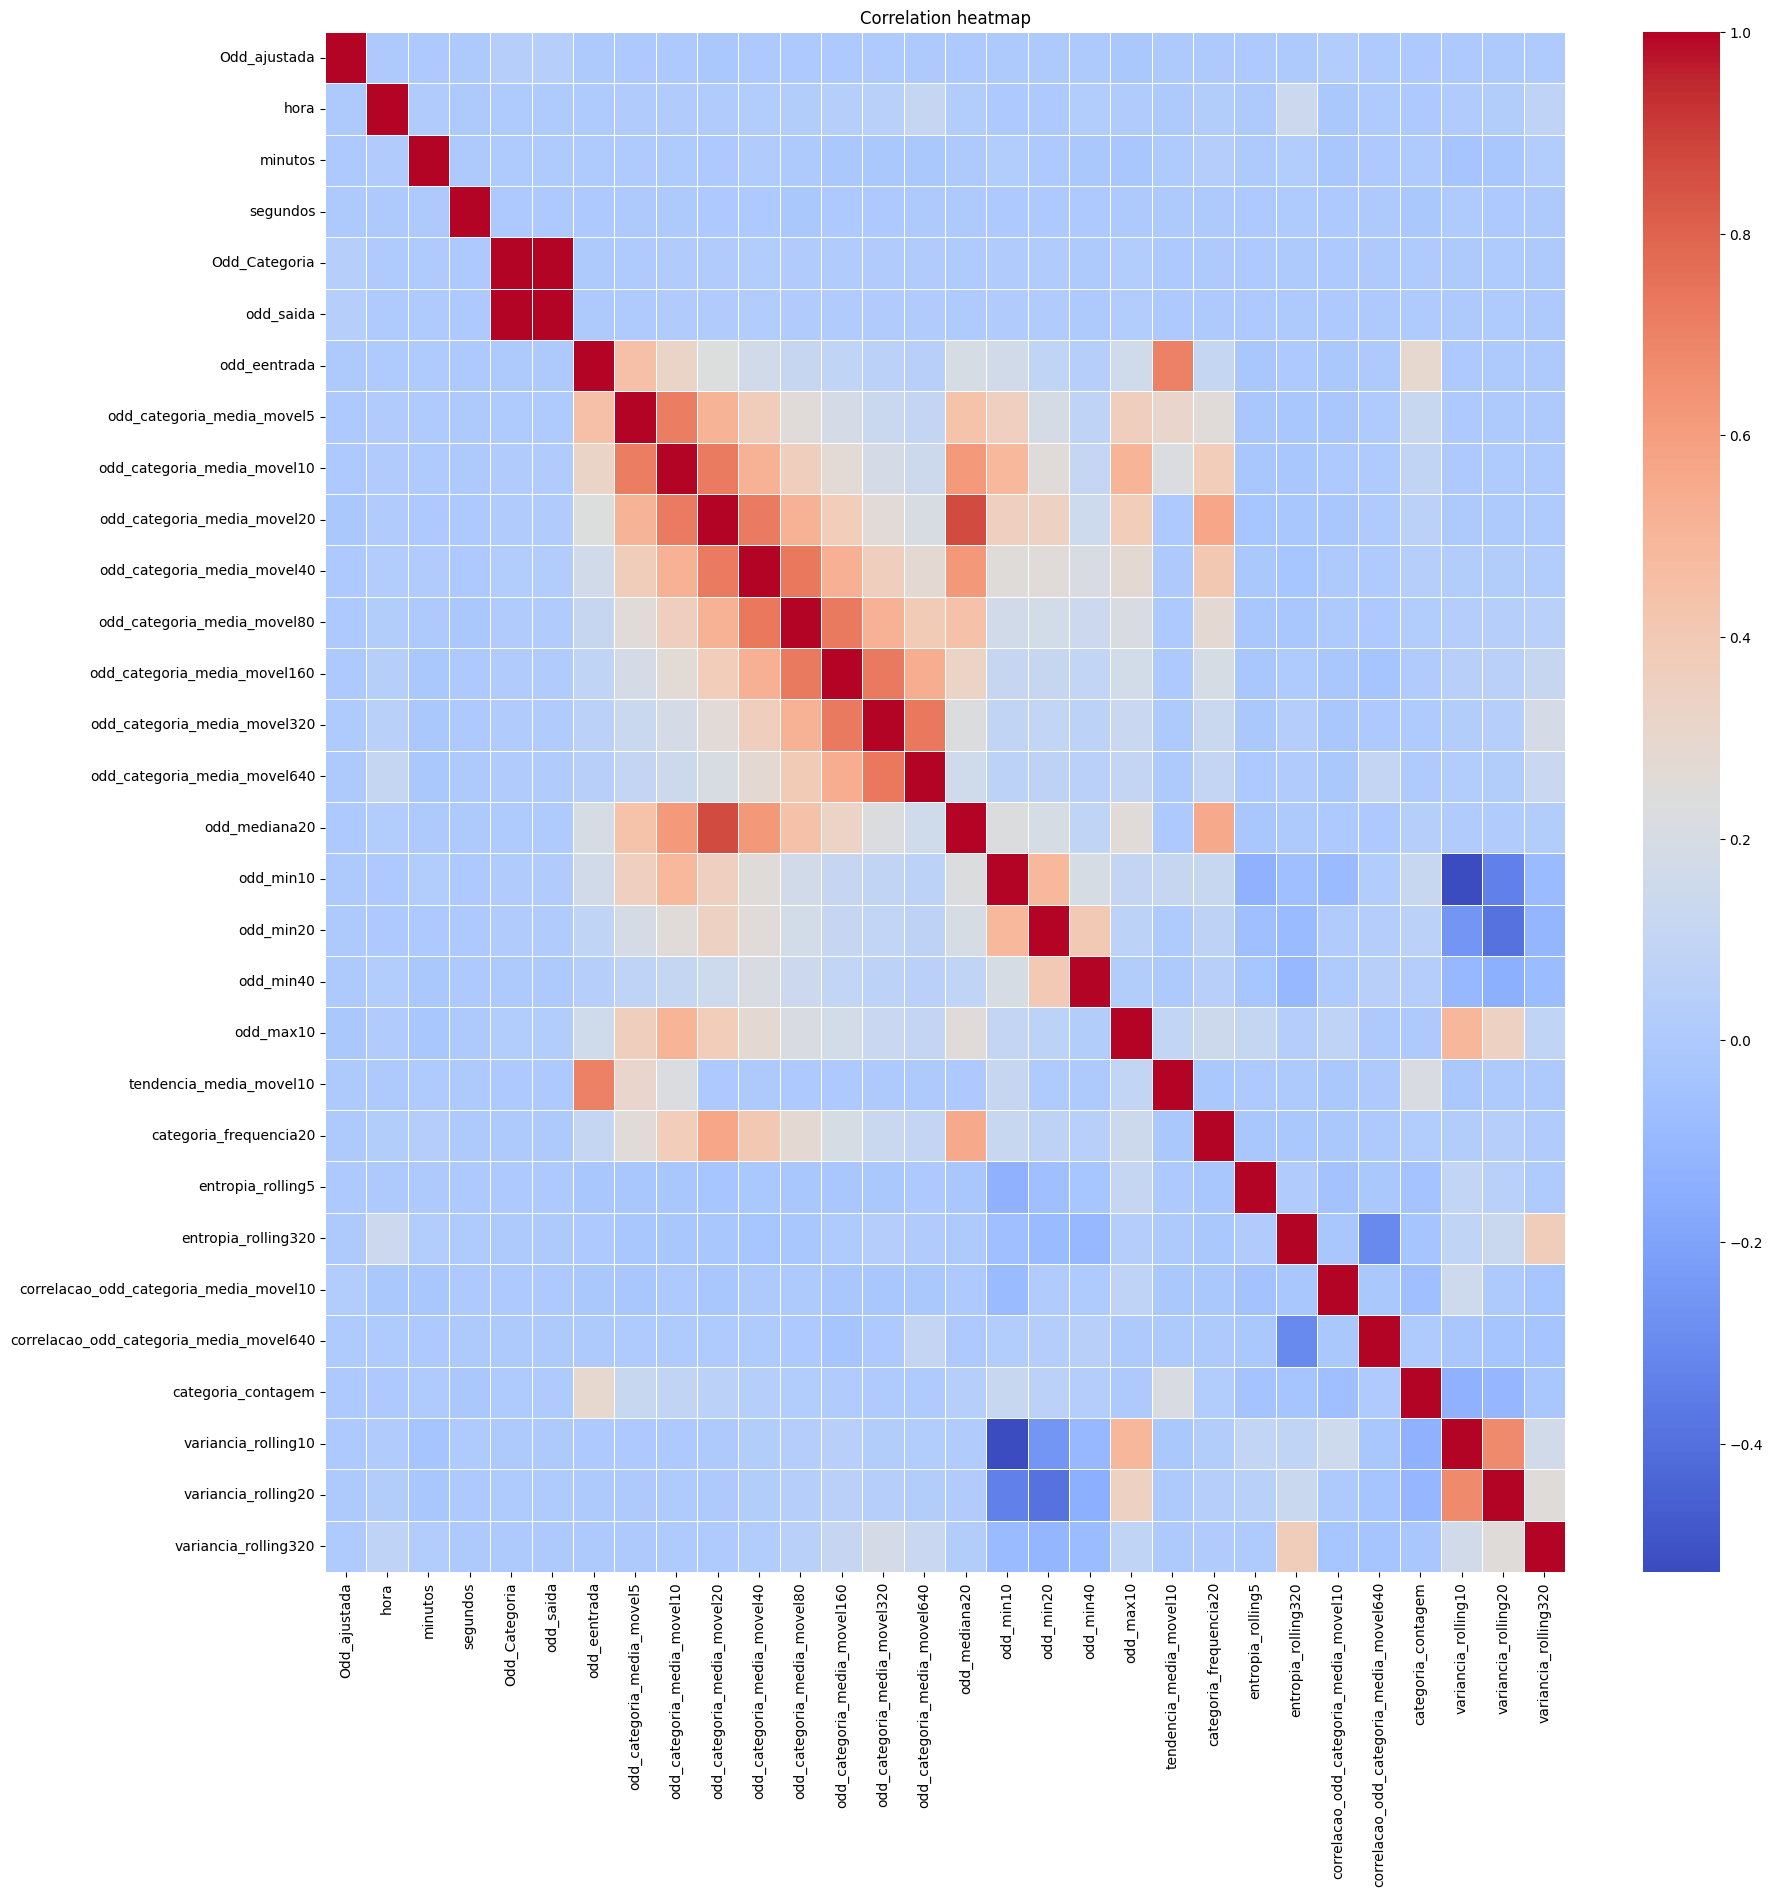

In [8]:
# Calculando a matriz de correlação
corr_matrix = data.corr()

# Criando o heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=.5)
plt.title('Correlation heatmap')
plt.show()

In [9]:
data.columns

Index(['Odd_ajustada', 'hora', 'minutos', 'segundos', 'horario',
       'Odd_Categoria', 'odd_saida', 'odd_eentrada',
       'odd_categoria_media_movel5', 'odd_categoria_media_movel10',
       'odd_categoria_media_movel20', 'odd_categoria_media_movel40',
       'odd_categoria_media_movel80', 'odd_categoria_media_movel160',
       'odd_categoria_media_movel320', 'odd_categoria_media_movel640',
       'odd_mediana20', 'odd_min10', 'odd_min20', 'odd_min40', 'odd_max10',
       'tendencia_media_movel10', 'categoria_frequencia20',
       'entropia_rolling5', 'entropia_rolling320',
       'correlacao_odd_categoria_media_movel10',
       'correlacao_odd_categoria_media_movel640', 'categoria_contagem',
       'variancia_rolling10', 'variancia_rolling20', 'variancia_rolling320'],
      dtype='object')

In [10]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Separar recursos (X) e rótulos (y)
X1 = data[['odd_eentrada',
       'odd_categoria_media_movel5', 'odd_categoria_media_movel10',
       'odd_categoria_media_movel20', 'odd_categoria_media_movel40',
       'odd_categoria_media_movel80', 'odd_categoria_media_movel160',
       'odd_categoria_media_movel320', 'odd_categoria_media_movel640',
       'odd_mediana20', 'odd_min10', 'odd_min20', 'odd_min40', 'odd_max10',
       'tendencia_media_movel10', 'categoria_frequencia20',
       'entropia_rolling5', 'entropia_rolling320',
       'correlacao_odd_categoria_media_movel10',
       'correlacao_odd_categoria_media_movel640', 'categoria_contagem',
       'variancia_rolling10', 'variancia_rolling20', 'variancia_rolling320']].values
y1 = data['Odd_Categoria'].values

scaler = StandardScaler()
X1 = scaler.fit_transform(X1)

# Divida os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Crie um modelo SVM para regressão
svm_regressor = SVR(kernel='linear')  # Pode escolher outros kernels também

# Treine o modelo no conjunto de treinamento
svm_regressor.fit(X_train, y_train)

# Faça previsões no conjunto de teste
y_pred = svm_regressor.predict(X_test)

# Avalie o desempenho do modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Erro Quadrático Médio (MSE):", mse)
print("Coeficiente de Determinação (R^2):", r2)


Erro Quadrático Médio (MSE): 9.598431041874907
Coeficiente de Determinação (R^2): 0.00039054927867043787


In [11]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Separar recursos (X) e rótulos (y)
X1 = data[['odd_eentrada',
       'odd_categoria_media_movel5', 'odd_categoria_media_movel10',
       'odd_categoria_media_movel20', 'odd_categoria_media_movel40',
       'odd_categoria_media_movel80', 'odd_categoria_media_movel160',
       'odd_categoria_media_movel320', 'odd_categoria_media_movel640',
       'odd_mediana20', 'odd_min10', 'odd_min20', 'odd_min40', 'odd_max10',
       'tendencia_media_movel10', 'categoria_frequencia20',
       'entropia_rolling5', 'entropia_rolling320',
       'correlacao_odd_categoria_media_movel10',
       'correlacao_odd_categoria_media_movel640', 'categoria_contagem',
       'variancia_rolling10', 'variancia_rolling20', 'variancia_rolling320']].values
y1 = data['Odd_Categoria'].values

scaler = StandardScaler()
X1 = scaler.fit_transform(X1)

# Divida os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Crie e treine o modelo Naive Bayes (usando Gaussian Naive Bayes neste exemplo)
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)

# Faça previsões
y_pred = naive_bayes.predict(X_test)

# Calcule o erro quadrático médio
mse = mean_squared_error(y_test, y_pred)
print(f"Erro Quadrático Médio (MSE): {mse}")


Erro Quadrático Médio (MSE): 18.113708399366086


In [ ]:
# Separar recursos (X) e rótulos (y)
X1 = data[['odd_eentrada',
       'odd_categoria_media_movel5', 'odd_categoria_media_movel10',
       'odd_categoria_media_movel20', 'odd_categoria_media_movel40',
       'odd_categoria_media_movel80', 'odd_categoria_media_movel160',
       'odd_categoria_media_movel320', 'odd_categoria_media_movel640',
       'odd_mediana20', 'odd_min10', 'odd_min20', 'odd_min40', 'odd_max10',
       'tendencia_media_movel10', 'categoria_frequencia20',
       'entropia_rolling5', 'entropia_rolling320',
       'correlacao_odd_categoria_media_movel10',
       'correlacao_odd_categoria_media_movel640', 'categoria_contagem',
       'variancia_rolling10', 'variancia_rolling20', 'variancia_rolling320']].values
y1 = data['Odd_Categoria'].values

# Normalizar os recursos (importante para redes neurais)
scaler1 = StandardScaler()
X1 = scaler1.fit_transform(X1)

# Dividir os dados em treinamento e teste
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Criar o modelo LSTM com camadas adicionais e dropout
model1 = Sequential()
model1.add(LSTM(320, input_shape=(X_train1.shape[1], 1), return_sequences=True))  # Camada LSTM com retorno de sequência
model1.add(Dropout(0.2))  # Camada de dropout para redução de overfitting
model1.add(LSTM(320))  # Segunda camada LSTM
model1.add(Dense(320, activation='relu', kernel_regularizer=l2(0.001)))  # Camada densa com regularização L2
model1.add(Dense(12, activation='softmax'))  # Camada de saída com ativação softmax para 11 categorias

# Compilar o modelo com uma taxa de aprendizado menor
model1.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# Treinar o modelo
model_train1 = model1.fit(X_train1.reshape(X_train1.shape[0], X_train1.shape[1], 1), y_train1, epochs=250, batch_size=160, validation_split=0.2)
#model_train

# Avaliar o modelo no conjunto de teste
accuracy = model1.evaluate(X_test1.reshape(X_test1.shape[0], X_test1.shape[1], 1), y_test1)[1]
print(f'Acurácia do modelo: {accuracy}')

# Fazer previsões
predictions = model1.predict(X_test1.reshape(X_test1.shape[0], X_test1.shape[1], 1))

# Arredondar as previsões para obter rótulos de classe
predicted_labels = np.argmax(predictions, axis=1)

# Calcular o F1-Score
f1 = f1_score(y_test1, predicted_labels, average='weighted')

print(f'F1-Score do modelo: {f1}')

Epoch 1/250
152/152 [==============================] - 133s 836ms/step - loss: 2.5205 - accuracy: 0.1057 - val_loss: 2.4357 - val_accuracy: 0.1105
Epoch 2/250
152/152 [==============================] - 125s 824ms/step - loss: 2.4164 - accuracy: 0.1075 - val_loss: 2.4046 - val_accuracy: 0.1105
Epoch 3/250
152/152 [==============================] - 123s 807ms/step - loss: 2.4029 - accuracy: 0.1076 - val_loss: 2.3974 - val_accuracy: 0.1105
Epoch 4/250
152/152 [==============================] - 123s 813ms/step - loss: 2.3986 - accuracy: 0.1095 - val_loss: 2.3980 - val_accuracy: 0.1105
Epoch 5/250
152/152 [==============================] - 122s 802ms/step - loss: 2.3967 - accuracy: 0.1098 - val_loss: 2.3969 - val_accuracy: 0.1105
Epoch 6/250
152/152 [==============================] - 123s 813ms/step - loss: 2.3960 - accuracy: 0.1115 - val_loss: 2.3935 - val_accuracy: 0.1105
Epoch 7/250
152/152 [==============================] - 122s 804ms/step - loss: 2.3953 - accuracy: 0.1099 - val_loss: 2